In [212]:
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')

from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import  MinMaxScaler, StandardScaler

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier

from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve,RocCurveDisplay,auc,plot_confusion_matrix,confusion_matrix,f1_score,balanced_accuracy_score,make_scorer
from sklearn.decomposition import PCA

from imblearn.over_sampling import SMOTE, BorderlineSMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import make_pipeline

from hpsklearn import HyperoptEstimator, any_classifier
from hyperopt import tpe

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

rs = 271828

1. One-hot encoder (categorical)
1. Train/Test split
2. missing value imputation
3. baseline model
    * Decision Tree Classifier
5. balance data set
    * SMOTE
    * Undersampling    
4. new features
    * Featuretools
    * PCA
    * AutoEncoder?
6. Modeling
    * Randomforest Classifer
    * XGBoost Classifier
    * Logistic Regression
    * Keras Classifier
7. Pipeline?
8. Streamlit?

In [9]:
df = pd.read_csv('data/abalone2.csv')

# 1. Create one-hot variable for categorical sex feature
#    remove original sex feature
df[['infant','male']] = pd.get_dummies(df.sex,drop_first=True)
del df['sex']

# Make 0.0 np.nan so that we can impute later
df.loc[df.height==0.,'height'] = np.nan

# Remove rings from X vector (this is a version of the respons)
x_features = ['length','diameter','height','whole_weight','shucked_weight','viscera_weight','shell_weight','weight_delta','infant','male']
X = df.loc[:,x_features]
y = df.loc[:,['y']]

# 2. Split the data set into Train/Test split
test_pct = 0.3
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_pct, random_state=rs)

print(f'X vector shape: {X.shape}')
print(f'y vector shape: {y.shape}')
print('-'*20)
print('Train/Test Split')
print(f'test pct: {test_pct:.2%}')
print('-'*20)
print(f'Train X: {X_train.shape}\tTrain y: {y_train.shape}')
print(f'Test X: {X_test.shape}\tTest y: {y_test.shape}')

X vector shape: (4177, 10)
y vector shape: (4177, 1)
--------------------
Train/Test Split
test pct: 30.00%
--------------------
Train X: (2923, 10)	Train y: (2923, 1)
Test X: (1254, 10)	Test y: (1254, 1)


In [10]:
# 3. Impute missing values
imputer = KNNImputer(n_neighbors=5)
X_train = pd.DataFrame(imputer.fit_transform(X_train),index=X_train.index,columns=X_train.columns)
X_test = pd.DataFrame(imputer.transform(X_test),index=X_test.index,columns=X_test.columns)

X_train.loc[df.height.isna(),:]
X_test.loc[df.height.isna(),:]

,length,diameter,height,whole_weight,shucked_weight,viscera_weight,shell_weight,weight_delta,infant,male
3996,0.315,0.23,0.090,0.134,0.0575,0.0285,0.3505,-0.3025,1.0,0.0
1257,0.430,0.34,0.115,0.428,0.2065,0.0860,0.1150,0.0205,1.0,0.0


,length,diameter,height,whole_weight,shucked_weight,viscera_weight,shell_weight,weight_delta,infant,male


In [237]:
def get_classification_metrics(model,X_train,y_train,X_test,y_test,model_name='default'):
    train_pred = model.predict(X_train)
    test_pred = model.predict(X_test)
    train_prob = model.predict_proba(X_train)[:,1]
    test_prob = model.predict_proba(X_test)[:,1]
    
    train_scores = classification_report(y_train,train_pred,output_dict=True)
    test_scores = classification_report(y_test,test_pred,output_dict=True)
    
    train_scores = pd.DataFrame(train_scores).T
    test_scores = pd.DataFrame(test_scores).T
    train_scores['model'] = model_name
    test_scores['model'] = model_name
    train_scores['split'] = 'train'
    test_scores['split'] = 'test'
    
    train_roc = roc_curve(y_train,train_prob,drop_intermediate=False)
    test_roc = roc_curve(y_test,test_prob,drop_intermediate=False)
    
    train_auc = auc(train_roc[0],train_roc[1])
    test_auc = auc(test_roc[0],test_roc[1])
    
    lw=2
    plt.plot(train_roc[0],train_roc[1],label=f'Train - AUC: {train_auc:.2f}',lw=lw)
    plt.plot(test_roc[0],test_roc[1],label=f'Test - AUC: {test_auc:.2f}',lw=lw)
    plt.plot(np.linspace(0,1,10),np.linspace(0,1,10),label='No Skill',c='black',linestyle='--',lw=lw)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'Reciever Operator Characteristic Curve\n{model_name}')
    plt.plot()
    plt.legend()
    plt.show()
    
    sns.heatmap(
        confusion_matrix(y_test,test_pred),
        annot=True,
        cmap='Blues',
        fmt='d'
    )
    plt.title(f'Confusion Matrix - Test\n{model_name}')
    plt.grid(False)
    plt.show()
    
    return pd.concat([train_scores,test_scores])

LogisticRegression()

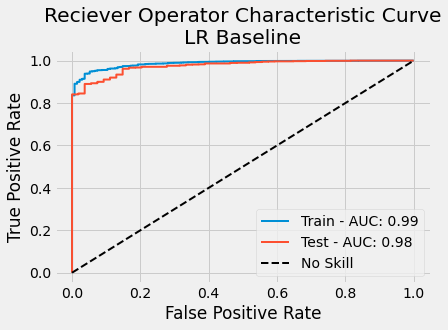

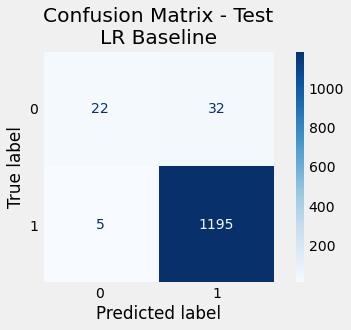

,precision,recall,f1-score,support,model,split
0,0.896104,0.511111,0.650943,135.000000,LR Baseline,train
1,0.976810,0.997131,0.986865,2788.000000,LR Baseline,train
accuracy,0.974684,0.974684,0.974684,0.974684,LR Baseline,train
macro avg,0.936457,0.754121,0.818904,2923.000000,LR Baseline,train
weighted avg,0.973082,0.974684,0.971351,2923.000000,LR Baseline,train
0,0.814815,0.407407,0.543210,54.000000,LR Baseline,test
1,0.973920,0.995833,0.984755,1200.000000,LR Baseline,test
accuracy,0.970494,0.970494,0.970494,0.970494,LR Baseline,test
macro avg,0.894367,0.701620,0.763982,1254.000000,LR Baseline,test
weighted avg,0.967069,0.970494,0.965741,1254.000000,LR Baseline,test


In [12]:
scores = []
lr_baseline = LogisticRegression()
lr_baseline.fit(X_train.values,y_train.values.ravel())
scores.append(get_classification_metrics(lr_baseline,X_train.values,y_train.values.ravel(),X_test.values,y_test.values.ravel(),model_name='LR Baseline'))
pd.concat(scores)

In [13]:
# put a note here about f1score ect

Pipeline(steps=[('smote', SMOTE()),
                ('logisticregression', LogisticRegression())])

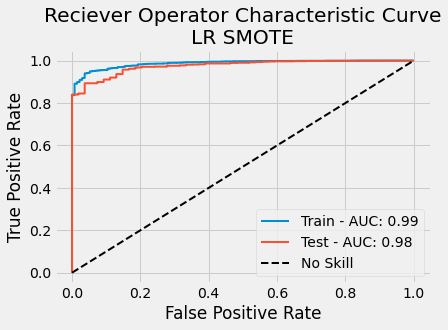

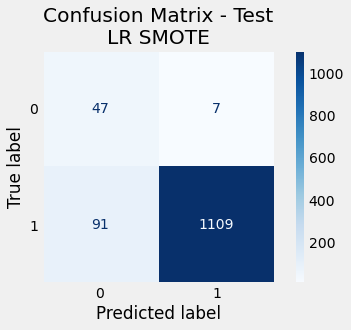

In [14]:
# SMOTE Only
lr_smote = LogisticRegression()
over = SMOTE()

model = make_pipeline(over,lr_smote)
model.fit(X_train.values,y_train.values.ravel())
scores.append(get_classification_metrics(model,X_train.values,y_train.values.ravel(),X_test.values,y_test.values.ravel(),model_name='LR SMOTE'))

Pipeline(steps=[('smote', SMOTE(sampling_strategy=0.2)),
                ('randomundersampler',
                 RandomUnderSampler(sampling_strategy=0.2)),
                ('logisticregression', LogisticRegression())])

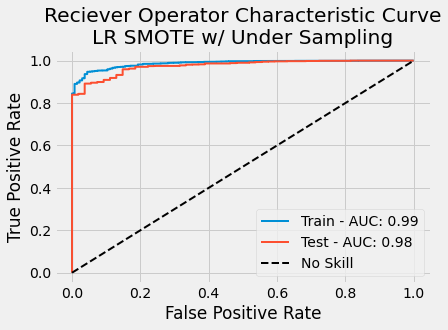

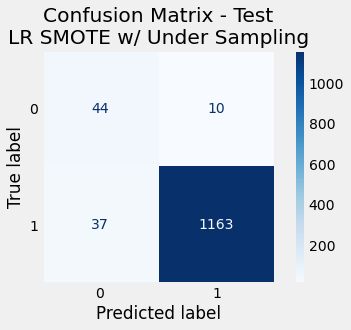

In [15]:
# SMOTE and Under Sampling
lr_smote = LogisticRegression()
over = SMOTE(sampling_strategy=0.20)
under = RandomUnderSampler(sampling_strategy=0.20)
model = make_pipeline(over,under,lr_smote)
model.fit(X_train.values,y_train.values.ravel())
scores.append(get_classification_metrics(model,X_train.values,y_train.values.ravel(),X_test.values,y_test.values.ravel(),model_name='LR SMOTE w/ Under Sampling'))

Pipeline(steps=[('smote', SMOTE(sampling_strategy=0.2)),
                ('randomundersampler',
                 RandomUnderSampler(sampling_strategy=0.2)),
                ('pca', PCA(n_components=0.95)),
                ('logisticregression', LogisticRegression())])

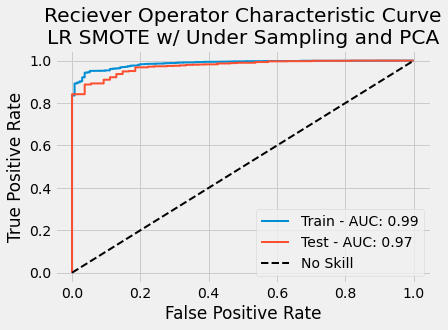

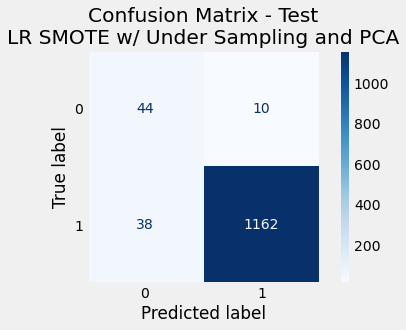

,precision,recall,f1-score,support,model,split
0,0.569307,0.851852,0.682493,135.000000,LR SMOTE w/ Under Sampling and PCA,train
1,0.992650,0.968795,0.980577,2788.000000,LR SMOTE w/ Under Sampling and PCA,train
accuracy,0.963394,0.963394,0.963394,0.963394,LR SMOTE w/ Under Sampling and PCA,train
macro avg,0.780978,0.910323,0.831535,2923.000000,LR SMOTE w/ Under Sampling and PCA,train
weighted avg,0.973097,0.963394,0.966810,2923.000000,LR SMOTE w/ Under Sampling and PCA,train
0,0.536585,0.814815,0.647059,54.000000,LR SMOTE w/ Under Sampling and PCA,test
1,0.991468,0.968333,0.979764,1200.000000,LR SMOTE w/ Under Sampling and PCA,test
accuracy,0.961722,0.961722,0.961722,0.961722,LR SMOTE w/ Under Sampling and PCA,test
macro avg,0.764026,0.891574,0.813411,1254.000000,LR SMOTE w/ Under Sampling and PCA,test
weighted avg,0.971879,0.961722,0.965437,1254.000000,LR SMOTE w/ Under Sampling and PCA,test


In [16]:
# SMOTE and Under Sampling AND PCA :)
lr_smote = LogisticRegression()
pca = PCA(n_components=0.95)
over = SMOTE(sampling_strategy=0.20)
under = RandomUnderSampler(sampling_strategy=0.20)

model = make_pipeline(over,under,pca,lr_smote)
model.fit(X_train.values,y_train.values.ravel())
get_classification_metrics(model,X_train.values,y_train.values.ravel(),X_test.values,y_test.values.ravel(),model_name='LR SMOTE w/ Under Sampling and PCA')

Pipeline(steps=[('smote', SMOTE(sampling_strategy=0.2)),
                ('randomundersampler',
                 RandomUnderSampler(sampling_strategy=0.2)),
                ('pca', PCA(n_components=0.95)),
                ('decisiontreeclassifier', DecisionTreeClassifier())])

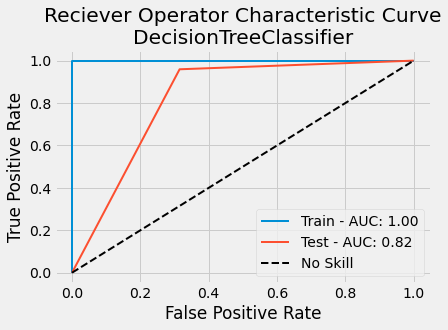

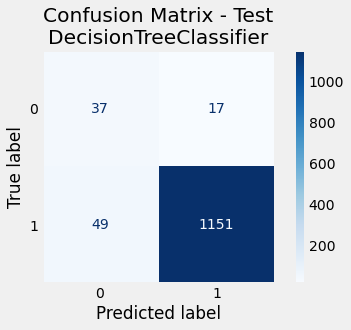

,precision,recall,f1-score,support,model,split
0,1.000000,1.000000,1.000000,135.000000,DecisionTreeClassifier,train
1,1.000000,1.000000,1.000000,2788.000000,DecisionTreeClassifier,train
accuracy,1.000000,1.000000,1.000000,1.000000,DecisionTreeClassifier,train
macro avg,1.000000,1.000000,1.000000,2923.000000,DecisionTreeClassifier,train
weighted avg,1.000000,1.000000,1.000000,2923.000000,DecisionTreeClassifier,train
0,0.430233,0.685185,0.528571,54.000000,DecisionTreeClassifier,test
1,0.985445,0.959167,0.972128,1200.000000,DecisionTreeClassifier,test
accuracy,0.947368,0.947368,0.947368,0.947368,DecisionTreeClassifier,test
macro avg,0.707839,0.822176,0.750350,1254.000000,DecisionTreeClassifier,test
weighted avg,0.961537,0.947368,0.953028,1254.000000,DecisionTreeClassifier,test


/home/nneuenschwander/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[04:29:25] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


Pipeline(steps=[('smote', SMOTE(sampling_strategy=0.2)),
                ('randomundersampler',
                 RandomUnderSampler(sampling_strategy=0.2)),
                ('pca', PCA(n_components=0.95)),
                ('xgbclassifier',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=1, gamma=0, gpu_id=-1,
                               importance_type='gain',
                               interaction_constraints='',
                               learning_rate=0.300000012, max_delta_step=0,
                               max_depth=6, min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=100,
                               n_jobs=8, num_parallel_tree=1, random_state=0,
                               reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
                               subsample=1, tree_meth

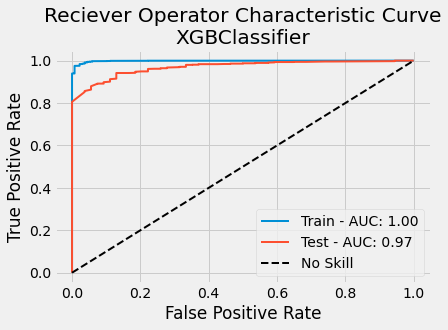

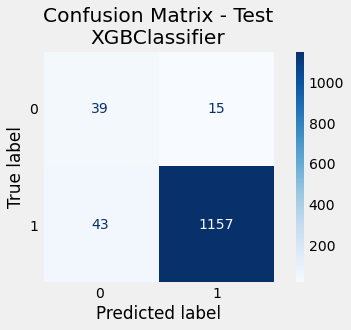

,precision,recall,f1-score,support,model,split
0,0.848684,0.955556,0.898955,135.000000,XGBClassifier,train
1,0.997835,0.991750,0.994783,2788.000000,XGBClassifier,train
accuracy,0.990079,0.990079,0.990079,0.990079,XGBClassifier,train
macro avg,0.923259,0.973653,0.946869,2923.000000,XGBClassifier,train
weighted avg,0.990946,0.990079,0.990357,2923.000000,XGBClassifier,train
0,0.475610,0.722222,0.573529,54.000000,XGBClassifier,test
1,0.987201,0.964167,0.975548,1200.000000,XGBClassifier,test
accuracy,0.953748,0.953748,0.953748,0.953748,XGBClassifier,test
macro avg,0.731406,0.843194,0.774539,1254.000000,XGBClassifier,test
weighted avg,0.965171,0.953748,0.958236,1254.000000,XGBClassifier,test


Pipeline(steps=[('smote', SMOTE(sampling_strategy=0.2)),
                ('randomundersampler',
                 RandomUnderSampler(sampling_strategy=0.2)),
                ('pca', PCA(n_components=0.95)),
                ('logisticregression', LogisticRegression())])

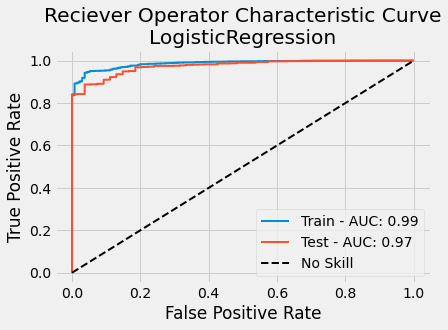

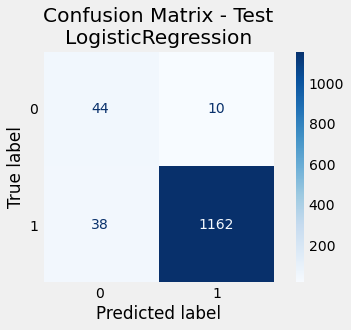

,precision,recall,f1-score,support,model,split
0,0.568627,0.859259,0.684366,135.000000,LogisticRegression,train
1,0.993012,0.968436,0.980570,2788.000000,LogisticRegression,train
accuracy,0.963394,0.963394,0.963394,0.963394,LogisticRegression,train
macro avg,0.780820,0.913848,0.832468,2923.000000,LogisticRegression,train
weighted avg,0.973412,0.963394,0.966890,2923.000000,LogisticRegression,train
0,0.536585,0.814815,0.647059,54.000000,LogisticRegression,test
1,0.991468,0.968333,0.979764,1200.000000,LogisticRegression,test
accuracy,0.961722,0.961722,0.961722,0.961722,LogisticRegression,test
macro avg,0.764026,0.891574,0.813411,1254.000000,LogisticRegression,test
weighted avg,0.971879,0.961722,0.965437,1254.000000,LogisticRegression,test


Pipeline(steps=[('smote', SMOTE(sampling_strategy=0.2)),
                ('randomundersampler',
                 RandomUnderSampler(sampling_strategy=0.2)),
                ('pca', PCA(n_components=0.95)),
                ('randomforestclassifier', RandomForestClassifier())])

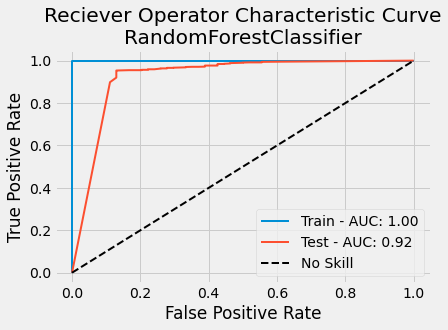

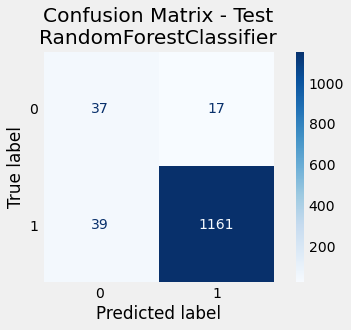

,precision,recall,f1-score,support,model,split
0,1.000000,1.000000,1.000000,135.000000,RandomForestClassifier,train
1,1.000000,1.000000,1.000000,2788.000000,RandomForestClassifier,train
accuracy,1.000000,1.000000,1.000000,1.000000,RandomForestClassifier,train
macro avg,1.000000,1.000000,1.000000,2923.000000,RandomForestClassifier,train
weighted avg,1.000000,1.000000,1.000000,2923.000000,RandomForestClassifier,train
0,0.486842,0.685185,0.569231,54.000000,RandomForestClassifier,test
1,0.985569,0.967500,0.976451,1200.000000,RandomForestClassifier,test
accuracy,0.955343,0.955343,0.955343,0.955343,RandomForestClassifier,test
macro avg,0.736205,0.826343,0.772841,1254.000000,RandomForestClassifier,test
weighted avg,0.964092,0.955343,0.958915,1254.000000,RandomForestClassifier,test


In [29]:
models = [ 
    DecisionTreeClassifier(), 
    XGBClassifier(),
    LogisticRegression(),
    RandomForestClassifier() 
]

for clf in models:
    pca = PCA(n_components=0.95)
    over = SMOTE(sampling_strategy=0.20)
    under = RandomUnderSampler(sampling_strategy=0.20)

    model = make_pipeline(over,under,pca,clf)
    model.fit(X_train.values,y_train.values.ravel())
    get_classification_metrics(model,X_train.values,y_train.values.ravel(),X_test.values,y_test.values.ravel(),model_name=f'{type(clf).__name__}')    

<AxesSubplot:xlabel='y', ylabel='count'>

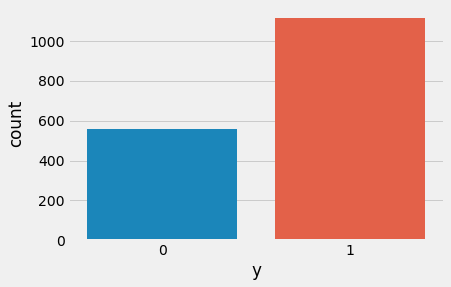

In [222]:
over = SMOTE(sampling_strategy=0.2)
under = RandomUnderSampler(sampling_strategy=0.5)
X_train_sample, y_train_sample = over.fit_resample(X_train,y_train)
X_train_sample, y_train_sample = under.fit_resample(X_train_sample, y_train_sample)

sns.countplot(x=y_train_sample.y)

In [232]:
from tpot import TPOTClassifier

def _balanced_accuracy_score(y_true, y_pred):
    from sklearn.metrics import balanced_accuracy_score
    return balanced_accuracy_score(y_true, y_pred)

balanced_accuracy_scorer = make_scorer(_balanced_accuracy_score, greater_is_better=True)
pipeline_optimizer = TPOTClassifier(generations=20, population_size=50, verbosity=2,)
pipeline_optimizer.fit(X_train_sample.values, y_train_sample.values.ravel())


Optimization Progress:   0%|          | 0/1050 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: 0.9646921083206721

Generation 2 - Current best internal CV score: 0.9646921083206721

Generation 3 - Current best internal CV score: 0.9646921083206721

Generation 4 - Current best internal CV score: 0.9646921083206721

Generation 5 - Current best internal CV score: 0.9652980605952275

Generation 6 - Current best internal CV score: 0.9652980605952275

Generation 7 - Current best internal CV score: 0.96768612029672

Generation 8 - Current best internal CV score: 0.96768612029672

Generation 9 - Current best internal CV score: 0.96768612029672

Generation 10 - Current best internal CV score: 0.9676879077665564

Generation 11 - Current best internal CV score: 0.9676879077665564

Generation 12 - Current best internal CV score: 0.9676879077665564

Generation 13 - Current best internal CV score: 0.9676879077665564

Generation 14 - Current best internal CV score: 0.9676879077665564

Generation 15 - Current best internal CV score: 0.967687907766

TPOTClassifier(generations=20, population_size=50, verbosity=2)

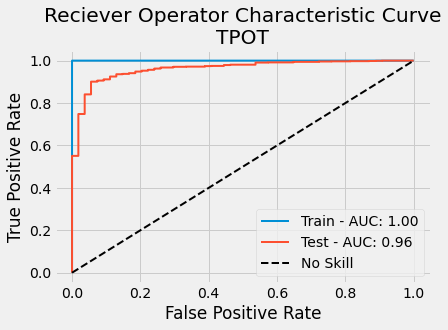

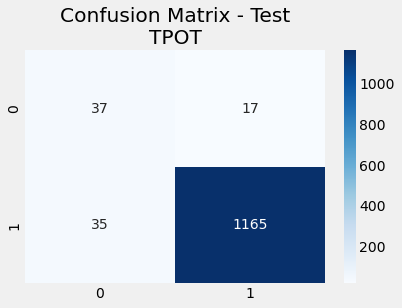

,precision,recall,f1-score,support,model,split
0,1.000000,1.000000,1.000000,557.000000,TPOT,train
1,1.000000,1.000000,1.000000,1114.000000,TPOT,train
accuracy,1.000000,1.000000,1.000000,1.000000,TPOT,train
macro avg,1.000000,1.000000,1.000000,1671.000000,TPOT,train
weighted avg,1.000000,1.000000,1.000000,1671.000000,TPOT,train
0,0.513889,0.685185,0.587302,54.000000,TPOT,test
1,0.985618,0.970833,0.978170,1200.000000,TPOT,test
accuracy,0.958533,0.958533,0.958533,0.958533,TPOT,test
macro avg,0.749753,0.828009,0.782736,1254.000000,TPOT,test
weighted avg,0.965304,0.958533,0.961338,1254.000000,TPOT,test


In [238]:
get_classification_metrics(
    pipeline_optimizer,
    X_train_sample.values,y_train_sample.values.ravel(),
    X_test.values,y_test.values.ravel(),
    model_name=f'TPOT'
)

In [144]:
estim = HyperoptEstimator(classifier=any_classifier('clf'),trial_timeout=3000)
estim.fit(X_train_sample.values,y_train_sample.values.ravel().astype(np.int32))
estim.retrain_best_model_on_full_data(X_train_sample.values,y_train_sample.values.ravel().astype(np.int32))

estim.best_model()
estim.score(X_test,y_test)

100%|████████████████████████████████████████████████| 10/10 [00:00<00:00,  2.06trial/s, best loss: 0.03381147540983609]


{'learner': RandomForestClassifier(bootstrap=False, criterion='entropy', max_features=None,
                        n_estimators=129, n_jobs=1, random_state=4,
                        verbose=False),
 'preprocs': (),
 'ex_preprocs': ()}

0.9529505582137161

RandomForestClassifier(bootstrap=False, criterion='entropy', max_features=None,
                       n_estimators=129, n_jobs=1, random_state=4,
                       verbose=False)

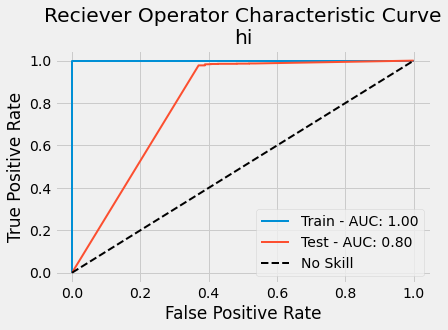

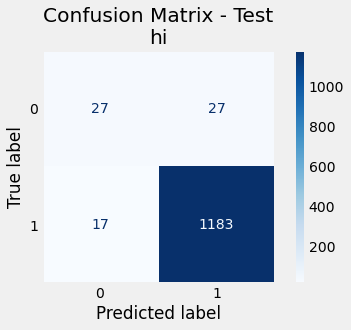

,precision,recall,f1-score,support,model,split
0,1.000000,1.000000,1.000000,557.000000,hi,train
1,1.000000,1.000000,1.000000,2785.000000,hi,train
accuracy,1.000000,1.000000,1.000000,1.000000,hi,train
macro avg,1.000000,1.000000,1.000000,3342.000000,hi,train
weighted avg,1.000000,1.000000,1.000000,3342.000000,hi,train
0,0.613636,0.500000,0.551020,54.000000,hi,test
1,0.977686,0.985833,0.981743,1200.000000,hi,test
accuracy,0.964912,0.964912,0.964912,0.964912,hi,test
macro avg,0.795661,0.742917,0.766382,1254.000000,hi,test
weighted avg,0.962009,0.964912,0.963195,1254.000000,hi,test


In [145]:
scaler = StandardScaler(with_mean=False)
m = RandomForestClassifier(bootstrap=False, criterion='entropy', max_features=None,
                        n_estimators=129, n_jobs=1, random_state=4,
                        verbose=False)

X_train_final = scaler.fit_transform(X_train_smote)
y_train_final = y_train_smote
X_test_final = scaler.transform(X_test)
y_test_final = y_test

m.fit(X_train_final, y_train_smote.values.ravel())

get_classification_metrics(m,X_train_final,y_train_final.values.ravel(),X_test_final,y_test.values.ravel(),model_name=f'hi')    

,y
0,0
1,0
2,0
3,0
4,0
...,...
3337,1
3338,1
3339,1
3340,1


In [130]:
import seaborn as sns
sns.countplot(x=pd.DataFrame(y_train_smote.astype(str)))

ValueError: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

<AxesSubplot:xlabel='y', ylabel='count'>

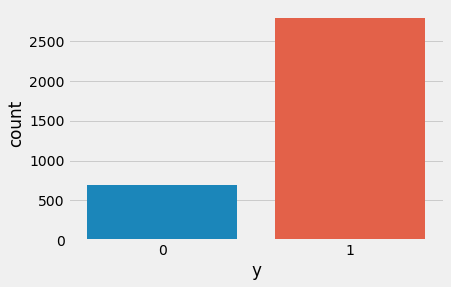

In [168]:
sns.countplot(x=y_train_sample.y)

0       0
1       0
2       0
3       0
4       0
       ..
3337    1
3338    1
3339    1
3340    1
3341    1
Name: y, Length: 3342, dtype: int64

In [7]:
y_test.shape

(7532,)